## Intro to RLlib
<!-- video shot="/AsZDP5ePn4s" start="00:01" end="14:49" -->

In [1]:
# HIDDEN
import gym
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

In [2]:
# HIDDEN
import ray
import logging
ray.init(log_to_driver=False, ignore_reinit_error=True, logging_level=logging.ERROR); # logging.FATAL

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#### Let's do some reinforcement learning!

Let's return to the "API" of RL:

![](img/RL-API.png)

- In Module 1, we talked about the input (environment) and output (policy)
- Let's talk about the reinforcement learning!

#### Introducing Ray RLlib

![](img/rllib-logo.png)

- In this course we'll use Ray RLlib as our "scikit-learn of reinforcement learning"
- We will look under the hood only as needed, and focus on applying RL/RLlib

#### Our first RLlib code

First, an import:

In [3]:
from ray.rllib.algorithms.ppo import PPO

- RLlib is part of the Ray project, hence `ray`
- In this course we'll mainly be focussing on the [PPO algorithm](https://openai.com/blog/openai-baselines-ppo/), hence `PPO`

Next, we create a PPO algorithm object:

In [5]:
# HIDDEN
from ray.rllib.algorithms.ppo import PPOConfig

algo_config = (
    PPOConfig()\
    .framework("torch")\
    .rollouts(create_env_on_local_worker=True)\
    .debugging(seed=0, log_level="ERROR", logger_config={"log_to_driver" : False})\
    .training(model={"fcnet_hiddens" : [32, 32]})\
    .environment(env_config={"is_slippery" : False})
)

In [6]:
ppo = PPO(env="FrozenLake-v1", config=algo_config)

- `PPO`: we're using the PPO algorithm
- `env="FrozenLake-v1"`: RLlib knows about OpenAI Gym environments
  - In the next module we'll learn how to make our own environments!
- `config=algo_config`: this contains all hyperparameters of the algorithm and the environment.
  - For clarity we've hidden the config for now, but we'll get back to it soon.
  
Notes:

- We can refer to gym environments by name
- Later we'll show the new standard way of instantiating algorithms

#### Using the policy

- We haven't trained the agent yet, but we can still see what it does.
- This is like calling `predict` before running `fit` with supervised learning.

In [7]:
env = gym.make("FrozenLake-v1", is_slippery=False)
obs = env.reset(seed=3)
obs

0

In [8]:
# HIDDEN
from utils import fix_frozen_lake_render
fix_frozen_lake_render(env)

In [9]:
action = ppo.compute_single_action(obs, explore=False)
action

2

- We gave the algorithm our initial observation, 0, and it recommended action 2 (right).
- This action came from the initialized **policy**.
- Remember, the policy maps observations to actions.
- For now we'll ignore the `explore=False`.

#### Using the policy

We can see what happened after taking that action:

In [10]:
obs, reward, done, _ = env.step(action)
env.render()

  (Right)
.P..
.O.O
...O
O..G


#### Training

- So far our policy was just a random/arbitrary initialization.
- What we want is to train it _based on experience interacting with the environment_.
- In order to do this, RLlib will _play through many episodes_ and learn as it goes.

In [11]:
train_info = ppo.train()

- Note that, unlike sklearn's `fit()`, here we don't provide the dataset to `train()`.
- We gave it the environment during initialization, and it uses the environment to generate data.

Notes:

The `train` method returns a dictionary containing information about the iteration of training. We'll explore this next.

#### Training iterations

- In fact, what we just did was one _iteration_ of training.
- RLlib will play through a bunch of episodes per iteration, depending on its hyperparameters.

In [12]:
len(train_info["hist_stats"]["episode_lengths"])

536

Looks like it ran ~500 episodes in that one iteration.

In [13]:
sum(train_info["hist_stats"]["episode_lengths"])

3991

For a total of ~4000 time steps.

#### RL mindset: data generation

- Key departure from the supervised learning mindset
- In SL, we take a fixed amount of data and train for some number of iterations
- In RL, more iterations means more training _on more data_ because we learn from the environment as we interact with it
- If you only play one episode, you might never see observation 10, so how can you learn what to do given observation 10?

#### RL mindset

What we had before, when we were controlling the agent manually:

![](img/RL-loop-2.png)

#### RL mindset

What we have now:

![](img/RL-loop-3.png)

We have an outer loop that involves training.

Notes:

Training / updating the agent may not necessarily occur after every single iteration, but this schematic gives a conceptual framework.

#### Training info: episode lengths

Let's look at the lengths of the last 100 episodes we played:

In [14]:
print(train_info["hist_stats"]["episode_lengths"][-100:])

[4, 9, 18, 3, 5, 2, 5, 5, 13, 18, 4, 6, 9, 3, 16, 4, 2, 3, 8, 4, 4, 4, 9, 6, 7, 2, 3, 6, 10, 9, 5, 7, 11, 19, 4, 7, 2, 2, 15, 6, 2, 10, 6, 13, 10, 11, 3, 10, 2, 8, 14, 12, 2, 4, 5, 2, 7, 4, 7, 5, 2, 3, 2, 6, 7, 2, 19, 2, 4, 12, 15, 7, 7, 11, 6, 2, 6, 6, 12, 6, 16, 8, 8, 4, 8, 4, 6, 4, 16, 2, 5, 11, 10, 6, 14, 2, 2, 6, 4, 14]


- Remember that an episode ends when `.step()` returns `True` for the `done` flag.
- We see some very short episodes, where the agent fell into a hole right away.

#### Training info: episode rewards

- For those longer episodes, did the agent reach the goal?
- To assess this, we can print out the last 100 _episode rewards_:

In [15]:
print(train_info["hist_stats"]["episode_reward"][-100:])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


And the average of these rewards:

In [16]:
print(np.mean(train_info["hist_stats"]["episode_reward"][-100:]))

0.03


This is not very impressive. Let's keep training.

#### More training

In [17]:
for i in range(10):
    train_info = ppo.train()

In [18]:
print(np.mean(train_info["hist_stats"]["episode_reward"]))

0.9778481012658228


- Nice! Now we're reaching the goal almost every time!
- The _average reward_ (across the most recent training episodes) is ~0.98.
- Interpretation: we're reaching the goal 98% of the time.

Notes:

Why this interpretation? Because in this environment, we only receive a reward at the end of the episode, 0 for failure and 1 for success.

#### Training curves

- In deep learning we often see diagrams of loss vs. epochs during training
- We can get this in RL too by storing this each iteration:

In [19]:
ppo = PPO(env="FrozenLake-v1", config=algo_config)

rewards = []
for i in range(10):
    train_info = ppo.train()
    rewards.append(train_info["episode_reward_mean"])

#### Training curves

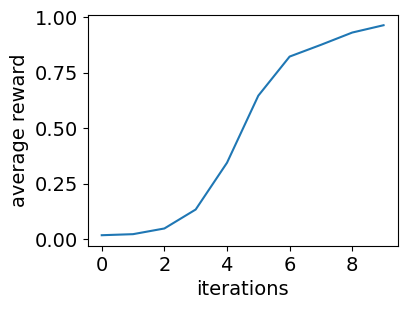

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,3))
plt.plot(rewards);
plt.xlabel("iterations");
plt.ylabel("average reward");

We can see the rewards increasing!

#### Declare victory?

- We did well.
- But, this non-slippery Frozen Lake is a very easy environment. 
- Kind of like a supervised learning dataset where y=x would be "easy".
- Later we'll ramp up the difficulty.

#### Using the policy

We can run the **observation-policy-action loop** for multiple time steps to watch the policy in action:

In [21]:
obs = env.reset()

for i in range(3):
    action = ppo.compute_single_action(obs, explore=False)
    obs, reward, done, _ = env.step(action)
    env.render()

  (Down)
....
PO.O
...O
O..G
  (Down)
....
.O.O
P..O
O..G
  (Right)
....
.O.O
.P.O
O..G


#### Using the policy

In [22]:
for i in range(3):
    action = ppo.compute_single_action(obs, explore=False)
    obs, reward, done, _ = env.step(action)
    env.render()

  (Right)
....
.O.O
..PO
O..G
  (Down)
....
.O.O
...O
O.PG
  (Right)
....
.O.O
...O
O..P


Using this policy we reliably reach the goal every time because the non-slippery Frozen Lake environment is deterministic.

#### Evaluation

In RLlib, we can evaluate with `.evaluate()`:

In [23]:
eval_results = ppo.evaluate()

Training does not occur during evaluation.

In [24]:
eval_results["evaluation"]["episode_reward_mean"]

0.9501557632398754

Here we get similar results to the output of `.train()`, though not exactly the same. 

Notes:

The evaluation output contains a lot of info, including many of the same fields as the training output.

#### Evaluation

Histogram of episode rewards:

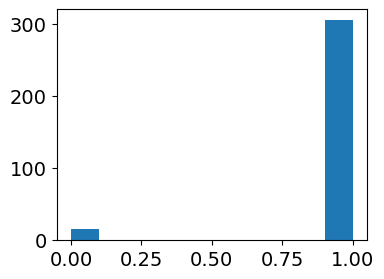

In [32]:
plt.figure(figsize=(4,3))
plt.hist(eval_results["evaluation"]["hist_stats"]["episode_reward"]);

#### Evaluation

Histogram of episode _lengths_:

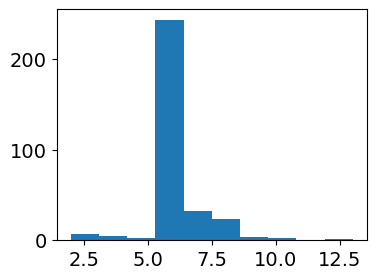

In [33]:
plt.figure(figsize=(4,3))
plt.hist(eval_results["evaluation"]["hist_stats"]["episode_lengths"]);

- The short ones are the failures, since it's impossible to reach the goal in 4 steps.
- Most of the time we reach the goal in the minimum number of steps (6).

#### sklearn / RLlib analogies

- We've seen some analogies (and departures) between SL and RL, both in concept and syntax. 
- Let's compare:

| SL/sklearn | RL/RLlib | Description  |
|-------------|---------|--------------|
| `ModelName(**hypers)` | `AlgoName(hypers, env)` | Initialize a model/algorithm |
| `.fit(X,y)`  | `.train()` | Training (fully for sklearn, one iteration for RLlib) |
| `.predict(x)` | `.compute_single_action(obs)` | Use the trained model once |
| `.score(X,y)` | `.evaluate()` | Evaluate the model |

#### Let's apply what we learned!

## RLlib algorithm methods
<!-- multiple choice -->

#### Training

_Which of the following most accurately describes the role of `algorithm.train()` in RLlib?_

- [ ] It neither collects a data set of episodes nor learns a policy. | Are you sure?
- [ ] It learns a policy from a fixed data set of episodes. | Remember, calling train() causes the agent to play through episodes.
- [ ] It creates a data set of episodes but does not learn a policy. | Remember, calling train() learns a policy.
- [x] It simultaneously collects a data set of episodes and also learns a policy. | You got it!

#### Passing in the dataset

_When using scikit-learn for supervised learning we call `fit(X,y)`, but with RLlib we call `train()` without passing in the dataset. Why?_

- [x] Because RLlib was given access to the environment when the algorithm was initialized, and this is all it needs.
- [ ] Because reinforcement learning does not involve data.
- [ ] Because X and y are passed into a different RLlib method.

#### Predicting

_Which of the following RLlib algorithm methods is most analogous to scikit-learn's `.predict()` function?_

- [ ] train() | This is more like _fit()_ in scikit-learn.
- [x] compute_single_action()
- [ ] evaluate() | This is more like _score()_ in scikit-learn. 

## Slippery Frozen Lake
<!-- coding exercise -->

In the slides, we trained an agent to reliably reach the goal in the **non-slippery** Frozen Lake environment. Here, try the same thing with the **slippery** Frozen Lake. Train your agent for enough iterations such it reaches the goal at least 20% of the time. Then, answer the multiple choice question below.

Note: we will discuss the algorithm config in the next set of slides. For now just note that we're using the slippery version of Frozen Lake.

In [25]:
# EXERCISE
from ray.rllib.algorithms.ppo import PPO, PPOConfig
from utils import slippery_algo_config

ppo = PPO(env=____, config=slippery_algo_config)

for i in range(____):
    train_info = ppo.____()
    
eval_results = ____.evaluate()

print(eval_results["evaluation"]["episode_reward_mean"])

NameError: name '____' is not defined

In [30]:
# SOLUTION
from ray.rllib.algorithms.ppo import PPO
from utils import slippery_algo_config

ppo = PPO(env="FrozenLake-v1", config=slippery_algo_config)

for i in range(50): # There is randomness here, but 20+ should be enough most of the time
    train_info = ppo.train()
    
eval_results = ppo.evaluate()

print("Frequency of reaching goal: %.1f%%" % (eval_results["evaluation"]["episode_reward_mean"]*100))

print("Action performed from top-right:", ppo.compute_single_action(3, explore=False))

Frequency of reaching goal: 87.0%
Action performed from top-right: 3


#### Action performed from top-right

According to the trained policy, what action is performed when the agent is at the top-right of the arena? This is printed out by the code.

- [ ] left (0) | When we ran the code, we got something different here.
- [ ] down (1) | When we ran the code, we got something different here.
- [ ] right (2) | When we ran the code, we got something different here.
- [x] up (3) | You got it!

#### Interpreting the policy

Recall that the arena looks like this:

```
SFFF
FHFH
FFFH
HFFG
```

In this slippery environment, you do your intended action 1/3 of the time, and each of the two perpendicular directions 1/3 of the time. You never go the opposite of the intended direction.

In the previous question, we saw that, from the **top-right corner** (observation 3), the agent tries to move up (action 3). Why do you think the agent tries to move up?

- [ ] 'Up' is an arbitrary choice because we did not train the agent.
- [ ] The agent receives a reward for the 'up' action. 
- [x] The agent wants to avoid falling into the hole below it, so the 'up' action is the safest choice.
- [ ] Moving up brings the agent closer to the goal.

In [31]:
# # HIDDEN

# from ray.rllib.algorithms.ppo import PPO, PPOConfig
# from utils import slippery_algo_config

# ppo = slippery_algo_config.build(env="FrozenLake-v1")

# for i in range(20):
#     ppo.train()

# ppo.save("models/FrozenLakeSlippery20")

## Rendering the trained agent
<!-- coding exercise -->

Fill in the blanks in the code below so that the code performs the observation-action-reward loop for one episode. Then, run the code and watch the trained agent navigate the slippery Frozen Lake. Then, answer the multiple choice question below.

In [32]:
# EXERCISE
from ray.rllib.algorithms.ppo import PPO
from utils import slippery_algo_config
import gym
from IPython import display
import time

ppo = PPO(env="FrozenLake-v1", config=slippery_algo_config)
ppo.from_checkpoint("models/FrozenLakeSlippery50/checkpoint_000050/")

env = gym.make("FrozenLake-v1", is_slippery=True)

obs = env.reset()
env.seed(12)

done = False
while not done:
    action = ppo.____(obs, explore=False)
    obs, rewards, done, _ = ____.step(____)

    display.clear_output(wait=True);
    print(env.render(mode="ansi"))
    time.sleep(0.25)

  (Down)
SFFF
FHFH
FFFH
HFFG



In [1]:
# SOLUTION
from ray.rllib.algorithms.ppo import PPO
from utils import slippery_algo_config
import gym
from IPython import display
import time

ppo = PPO(env="FrozenLake-v1", config=slippery_algo_config)
ppo.from_checkpoint("models/FrozenLakeSlippery50/checkpoint_000050/")

env = gym.make("FrozenLake-v1", is_slippery=True)

obs = env.reset()
env.seed(12)

done = False
while not done:
    action = ppo.compute_single_action(obs, explore=False)
    obs, rewards, done, _ = env.step(action)

    display.clear_output(wait=True);
    print(env.render(mode="ansi"))
    time.sleep(0.25)

  (Down)
SFFF
FHFH
FFFH
HFFG



#### Choose the option below that best describes the agent's treacherous journey to the goal.

- [ ] The agent visits the top-right square in this episode.
- [ ] The agent never returns to the start state after leaving it initially.
- [ ] The agent does not reach the goal during the episode.
- [x] The agent never sees observation 10 on its journey.